<a href="https://colab.research.google.com/github/hiendinh2001/Brain_Tumors_Classification_project/blob/main/projet_Brain_Tumors_Classification_DINH_KORENFELD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imagerie médicale : Détection de tumeur cérébrale dans les images IRM**

## **Jeu de données**

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

## **Algorithmes : Transformers with attention rollout or heatmaps**

https://keras.io/examples/vision/probing_vits/

# **Introduction**

Dans ce notebook, j'ai utilisé **CNN** pour effectuer la classification d'images sur le jeu de données de tumeurs cérébrales.<br>
Étant donné que ce jeu de données est petit, entraîner un réseau de neurones dessus ne donnera pas de bons résultats.<br>
Par conséquent, je vais utiliser le concept de **l'apprentissage par transfert** pour entraîner le modèle et obtenir des résultats très précis.

<img src="https://miro.medium.com/max/2800/1*TUF_YfybJPQ8WA0siWeJTg@2x.jpeg" alt="Brain" style="width: 800px;">

# **Étape 1 : Importation des bibliothèques**

In [1]:
# Importation de la bibliothèque matplotlib pour créer des visualisations graphiques
import matplotlib.pyplot as plt

# Importation de la bibliothèque NumPy pour les calculs numériques
import numpy as np

# Importation de la bibliothèque pandas pour la manipulation et l'analyse des données
import pandas as pd

# Importation de la bibliothèque seaborn pour la visualisation de données basée sur matplotlib
import seaborn as sns

# Importation de la bibliothèque OpenCV pour le traitement d'images
import cv2

# Importation de la bibliothèque TensorFlow pour l'apprentissage automatique
import tensorflow as tf

# Importation de la classe ImageDataGenerator de tensorflow.keras.preprocessing.image pour générer des lots de données d'image avec augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importation de tqdm pour afficher des barres de progression
from tqdm import tqdm

# Importation de la bibliothèque os pour les opérations de système d'exploitation
import os

# Importation de shuffle de sklearn.utils pour mélanger les données
from sklearn.utils import shuffle

# Importation de train_test_split de sklearn.model_selection pour diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# Importation du modèle EfficientNetB0 de tensorflow.keras.applications pour utiliser un modèle pré-entraîné
from tensorflow.keras.applications import EfficientNetB0

# Importation des callbacks pour contrôler le processus d'entraînement
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Importation des fonctions pour évaluer les performances du modèle
from sklearn.metrics import classification_report, confusion_matrix

# Importation de ipywidgets pour créer des widgets interactifs dans les notebooks Jupyter
import ipywidgets as widgets

# Importation de io pour gérer les flux d'entrée/sortie
import io

# Importation de la classe Image de PIL pour la manipulation d'images
from PIL import Image

# Importation des fonctions display et clear_output de IPython.display pour afficher et effacer des sorties dans les notebooks Jupyter
from IPython.display import display, clear_output

# Importation de filterwarnings pour filtrer les avertissements
from warnings import filterwarnings

In [2]:
# Importation de la fonction files depuis le module google.colab pour charger des fichiers
from google.colab import files

# Importation de la bibliothèque zipfile pour manipuler des fichiers ZIP
import zipfile

# Importation de la bibliothèque io pour les opérations d'entrée/sortie
import io

# **Étape 2 : Définition et visualisation des palettes de couleurs**

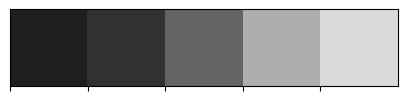

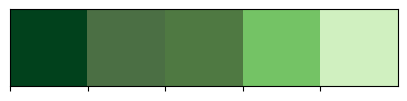

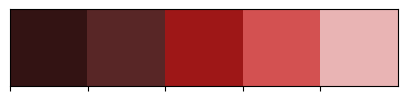

In [3]:
# Définition des palettes de couleurs sombres, rouges et vertes
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

# Visualisation des palettes de couleurs avec seaborn
sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# **Étape 3 : Chargement du fichier téléchargé**


In [ ]:
# Chargement du fichier téléchargé
uploaded = files.upload()

# Nom du fichier ZIP téléchargé
zip_file_name = "brain_tumor.zip"

# Extraction du contenu du fichier ZIP
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall()

KeyError: 'brain_tumor.zip'

In [4]:
# Montage du drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Étape 4 : Préparation des données**



In [ ]:
# Définition des labels pour les différentes catégories de tumeurs
labels = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [ ]:
# Initialisation des listes pour les images et leurs labels
X_train = []
y_train = []
image_size = 150

In [ ]:
# Chargement des images de l'ensemble d'entraînement
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

100%|██████████| 827/827 [00:38<00:00, 21.35it/s]


In [ ]:
# Chargement des images de l'ensemble de test
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification', 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

100%|██████████| 74/74 [00:26<00:00,  2.75it/s]


In [ ]:
# Conversion des listes en tableaux NumPy
X_train = np.array(X_train)
y_train = np.array(y_train)

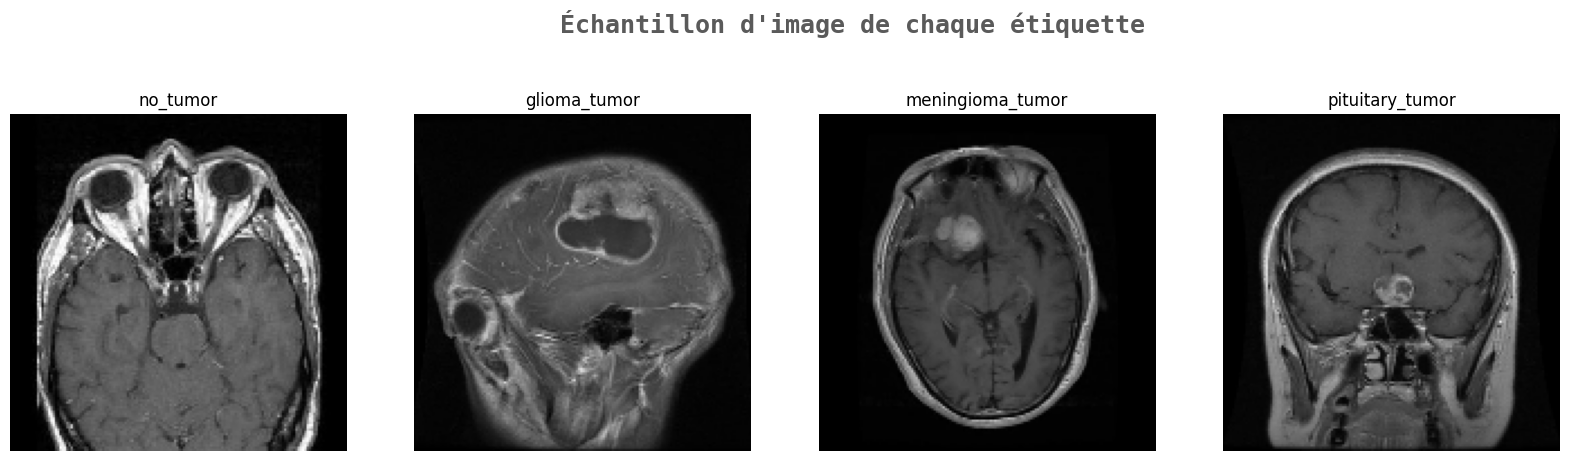

In [ ]:
# Affichage d'un échantillon d'image de chaque label
k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s="Échantillon d'image de chaque étiquette", size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

In [ ]:
# Mélange des données
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [ ]:
# Affichage de la forme du tableau des données d'entraînement
print(X_train.shape)

(3264, 150, 150, 3)


In [ ]:
# Division du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

In [ ]:
# Conversion des labels en indices puis en vecteurs binaires pour l'entraînement
y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)

In [ ]:
# Conversion des labels de test en indices puis en vecteurs binaires pour l'évaluation
y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new)

# **Étape 5 : Apprentissage par transfert**


Les modèles de réseaux neuronaux convolutifs (CNN) profonds peuvent prendre des jours, voire des semaines, pour s'entraîner sur de très grands ensembles de données.

Une façon de raccourcir ce processus est de réutiliser les poids des modèles pré-entraînés qui ont été développés pour des ensembles de données de référence en vision par ordinateur standard, tels que les tâches de reconnaissance d'images ImageNet.
Les modèles les plus performants peuvent être téléchargés et utilisés directement, ou intégrés dans un nouveau modèle pour nos propres problèmes de vision par ordinateur.

Dans ce notebook, j'utiliserai le modèle **EfficientNetB0** qui utilisera les poids du dataset **ImageNet**.

Le paramètre include_top est défini sur False afin que le réseau n'inclue pas la couche supérieure / couche de sortie du modèle pré-construit, ce qui nous permet d'ajouter notre propre couche de sortie en fonction de notre cas d'utilisation!


In [ ]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

16705208/16705208 [==============================] - 0s 0us/step


**GlobalAveragePooling2D** -> Cette couche fonctionne de manière similaire à la couche de max-pooling dans les CNNs, la seule différence étant qu'elle utilise les valeurs moyennes au lieu de la valeur maximale lors du pooling. Cela aide vraiment à réduire la charge de calcul sur la machine pendant l'entraînement.

**Dropout** -> Cette couche omet certains des neurones à chaque étape de la couche, rendant les neurones plus indépendants des neurones voisins. Cela aide à éviter le surapprentissage. Les neurones à omettre sont sélectionnés de manière aléatoire. Le paramètre rate est la probabilité qu'une activation de neurone soit définie à 0, donc supprimant le neurone.

**Dense** -> Ceci est la couche de sortie qui classe l'image dans l'une des 4 classes possibles. Elle utilise la fonction softmax qui est une généralisation de la fonction sigmoïde.


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)

In [ ]:
# Affiche un résumé du modèle
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

Nous compilons enfin notre modèle.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

**Callbacks** -> Les callbacks peuvent vous aider à corriger les bogues plus rapidement et à construire de meilleurs modèles. Ils peuvent nous aider à visualiser la progression de l'entraînement de notre modèle et peuvent même aider à prévenir le surapprentissage en implémentant un arrêt anticipé ou en personnalisant le taux d'apprentissage à chaque itération.

Par définition, "Un callback est un ensemble de fonctions à appliquer à des étapes données de la procédure d'entraînement. Vous pouvez utiliser les callbacks pour obtenir une vue sur les états internes et les statistiques du modèle pendant l'entraînement."

Dans ce notebook, j'utiliserai les fonctions de callback **TensorBoard, ModelCheckpoint et ReduceLROnPlateau**.


In [ ]:
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

# **Étape 6 : Entraînement du modèle**

In [ ]:
# Entraînement du modèle avec les données d'entraînement
history = model.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=32,
                    callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.8176
Epoch 1: val_accuracy improved from -inf to 0.87755, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 395s 4s/step - loss: 0.4770 - accuracy: 0.8176 - val_loss: 0.3369 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9357
Epoch 2: val_accuracy improved from 0.87755 to 0.93878, saving model to effnet.h5
83/83 [==============================] - 356s 4s/step - loss: 0.1849 - accuracy: 0.9357 - val_loss: 0.2393 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9535
Epoch 3: val_accuracy did not improve from 0.93878
83/83 [==============================] - 361s 4s/step - loss: 0.1340 - accuracy: 0.9535 - val_loss: 0.3195 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9735
Epoch 4: val_accuracy did not improve from 0.93878

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [=====================

In [ ]:
# Sauvegarde du modèle entraîné
model.save('/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/model_Brain_Tumors_Classification_2.h5')

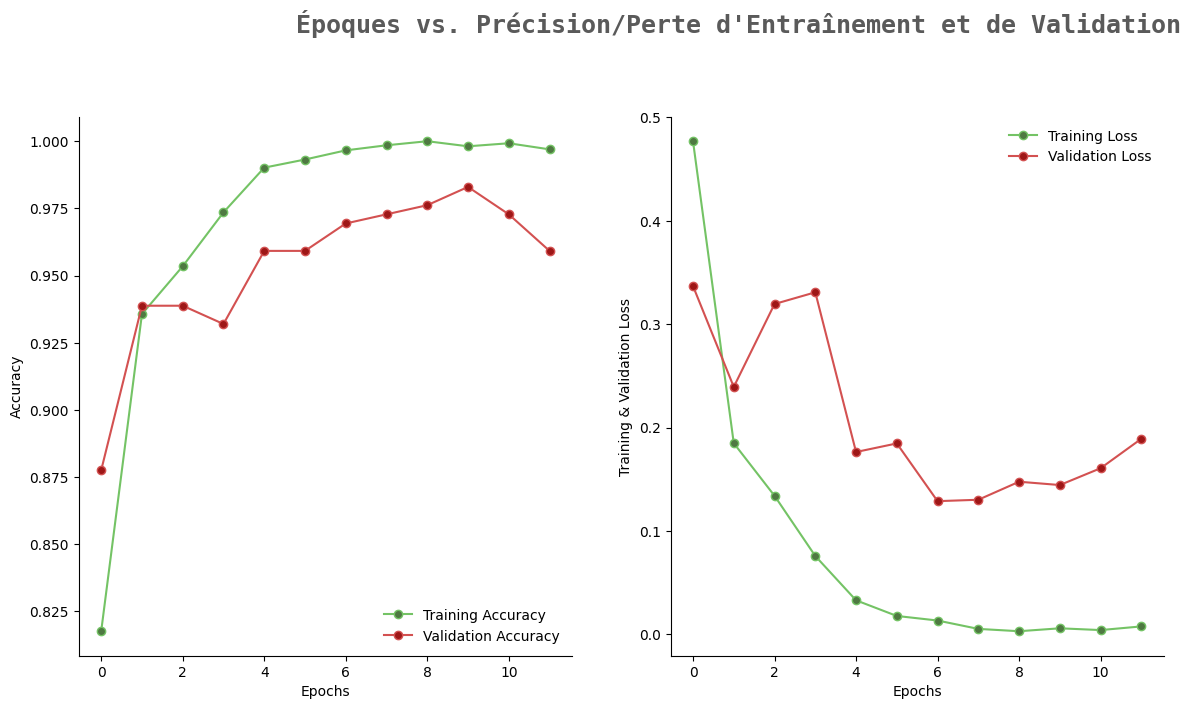

In [ ]:
# Suppression des avertissements pour une sortie plus propre
filterwarnings('ignore')

# Création des listes d'époques pour l'axe des x
epochs = [i for i in range(12)]

# Création de la figure et des axes pour les graphiques
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Récupération de l'historique de l'entraînement
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Affichage du titre des graphiques
fig.text(s="Époques vs. Précision/Perte d'Entraînement et de Validation", size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

# Réglage de l'apparence des graphiques
sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# **Étape 7 : Prédiction**

J'ai utilisé la fonction **argmax** car chaque ligne du tableau de prédiction contient quatre valeurs pour les étiquettes respectives.
La valeur **maximale** qui se trouve dans chaque ligne représente la sortie prédite parmi les 4 résultats possibles.
Donc avec **argmax**, je suis en mesure de trouver l'indice associé à la sortie prédite.


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

11/11 [==============================] - 13s 993ms/step


# **Étape 8 : Évaluation**

Dans ce rapport,
- 0 - Pas de Tumeur
- 1 - Tumeur Gliome
- 2 - Tumeur Méningiome
- 3 - Tumeur Pituitaire

In [ ]:
print(classification_report(y_test_new, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.99      0.96      0.97        90
           2       0.97      0.94      0.95        96
           3       0.94      1.00      0.97        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



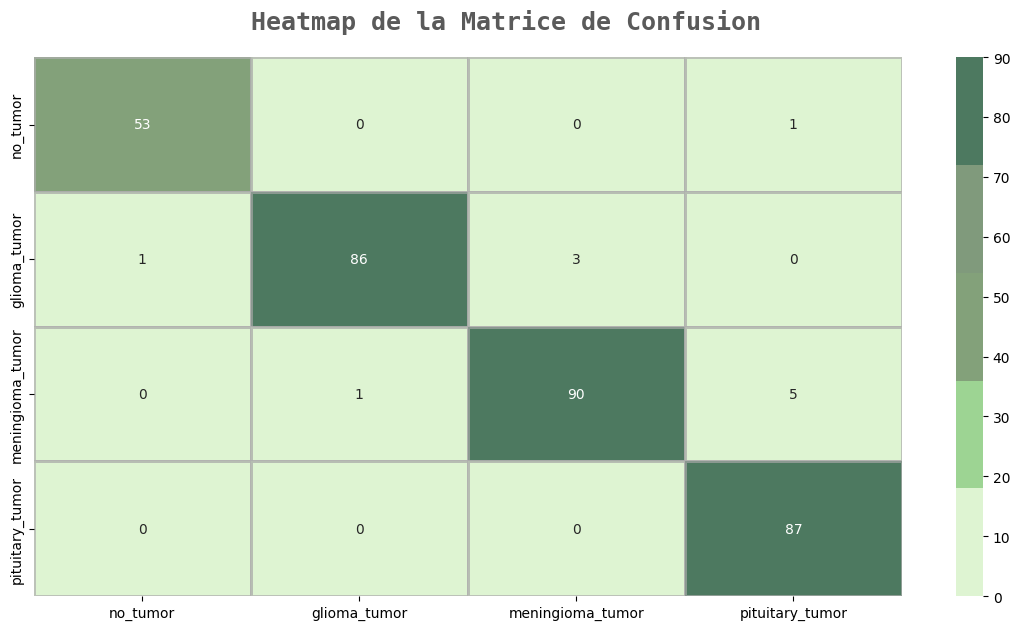

In [ ]:
# Affichage de la heatmap de la matrice de confusion
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap de la Matrice de Confusion', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

# **Étape 9 : Prédiction de la classe pour une image**



In [14]:
def classify_brain_tumor(image_path, model):
    # Chargement de l'image
    image = cv2.imread(image_path)

    # Vérification que l'image est bien chargée
    if image is None:
        raise ValueError(f"Image non trouvée au chemin : {image_path}")

    # Redimensionnement de l'image
    img = Image.fromarray(image)
    img = img.resize((150, 150))  # Ajustement de la taille pour correspondre à la taille d'entrée du modèle
    img = np.array(img)

    # Prétraitement de l'image pour l'entrée du modèle
    input_img = np.expand_dims(img, axis=0)

    # Prédiction de la classe pour l'image
    predictions = model.predict(input_img)

    # Extraction de la classe prédite
    predicted_class = np.argmax(predictions)

    # Définition des noms de classes
    class_names = {
        0: "Pas de tumeur",
        1: "Gliome tumeur",
        2: "Meningiome tumeur",
        3: "Pituitaire tumeur"
    }

    # Interprétation de la classe prédite
    if predicted_class in class_names:
        prediction_label = class_names[predicted_class]
    else:
        prediction_label = "Classe prédite non reconnue"

    # Affichage de l'image avec la prédiction de classe
    plt.imshow(image)
    plt.title(prediction_label)
    plt.axis('off')
    plt.show()

    return prediction_label

In [11]:
from tensorflow.keras.models import load_model

# Chargement du modèle sauvegardé
model = load_model('/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/model_Brain_Tumors_Classification_2.h5')

1/1 [==============================] - 2s 2s/step


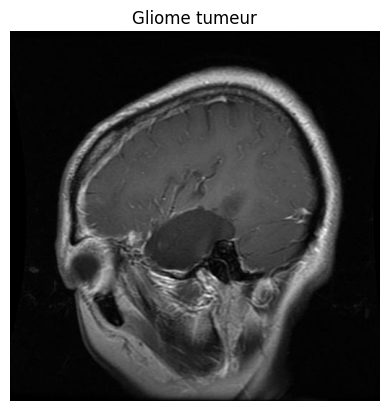

In [13]:
image_path = '/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/Training/glioma_tumor/gg (100).jpg'
prediction_label = classify_brain_tumor(image_path, model)

1/1 [==============================] - 0s 84ms/step


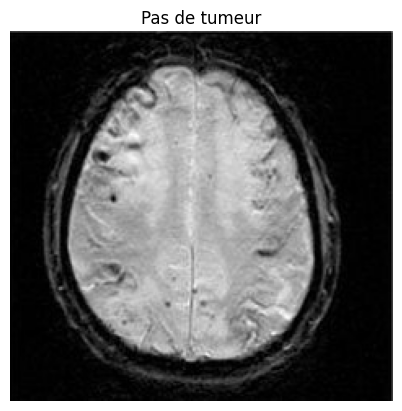

In [15]:
image_path = '/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/Testing/no_tumor/image(12).jpg'
prediction_label = classify_brain_tumor(image_path, model)

1/1 [==============================] - 0s 171ms/step


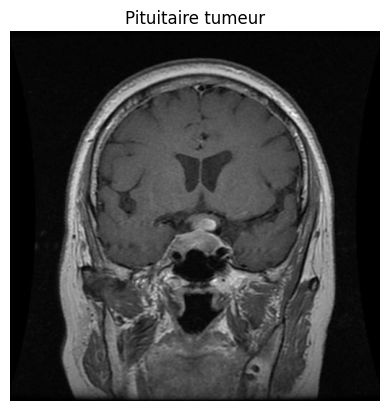

In [16]:
image_path = '/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/Training/pituitary_tumor/p (106).jpg'
prediction_label = classify_brain_tumor(image_path, model)

1/1 [==============================] - 0s 93ms/step


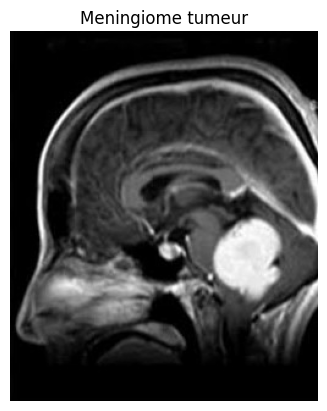

In [17]:
image_path = '/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/Testing/meningioma_tumor/image(23).jpg'
prediction_label = classify_brain_tumor(image_path, model)

1/1 [==============================] - 0s 101ms/step


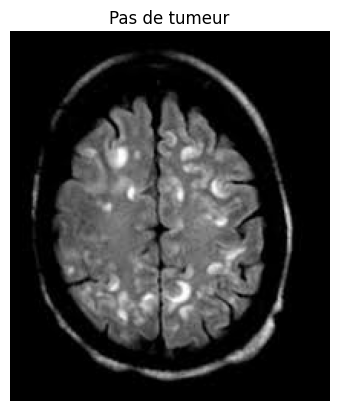

In [18]:
image_path = '/content/drive/MyDrive/Colab Notebooks/projet_Brain_Tumors_Classification/Training/no_tumor/image (7).jpg'
prediction_label = classify_brain_tumor(image_path, model)

# **Étape 10 : Widgets**

J'ai créé ces widgets dans lesquels nous pouvons télécharger des images depuis notre machine locale et prédire si la scanographie par résonance magnétique (IRM) comporte une tumeur cérébrale ou non, et pour classer de quel type de tumeur il s'agit.


In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (150, 150))
    img = img.reshape(1, 150, 150, 3)
    p = model.predict(img)
    p = np.argmax(p, axis=1)[0]

    if p == 0:
        print("Le modèle prédit qu'il n'y a pas de tumeur")
    elif p == 1:
        p = 'Tumeur Gliome'
    elif p == 2:
        p = 'Tumeur Méningiome'
    else:
        p = 'Tumeur Pituitaire'

    if p != 0:
        print(f"Le modèle prédit que c'est une {p}")

C'est ici que nous pouvons télécharger l'image en cliquant sur le bouton Télécharger :

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

Après avoir téléchargé l'image, nous pouvons cliquer sur le bouton Prédire ci-dessous pour effectuer des prédictions :


In [ ]:
button = widgets.Button(description='Prédire')
out = widgets.Output()

def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print("Aucune image téléchargée/Fichier image non valide")

button.on_click(on_button_clicked)
widgets.VBox([button, out])